# Installing libraries

In [1]:
!pip install contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 8.4 MB/s eta 0:00:00


# Importing library and modules

In [2]:
# Importing the data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing libraries
import re
import contractions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importing the model building libraries
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Importing the evaluation libraries
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Importing the XAI libraries
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Reading and loading the data

In [3]:
df = pd.read_csv("/kaggle/input/pandemic-tweet-challenge/Pandemic_NLP_train.csv", encoding='ISO-8859-1')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


# Note

**Task:** Dropping all irrelevant columns.

**Reason:** Dropping all other columns because only two columns are relevant here. Those are, 'OriginalTweet' (Feature column) and 'Sentiment' (Target column) to make the prediction.
    


In [4]:
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


# Note

**Task:** Checking for null values

**Result:** No null values present in the dataset.

In [5]:
null_count = df.isnull().sum()
null_count

OriginalTweet    0
Sentiment        0
dtype: int64

# Note

**Task:** Seeing the number of prediction classes.

**Result:** The target column ('Sentiment'column) has 5 unique values. There are 5 classes in total and the model will do classification based on those 5 target classes.

In [6]:
uniq_cols = df["Sentiment"].unique()
print(uniq_cols)
print()
print(len(uniq_cols))

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']

5


# Note

**Task:** Generating the descriptive statistics of the prediction column.

**Reason:** To gain insightful summary statistics for different classes of the prediction column of our dataset. This also provides us an understanding of the data distribution.

In [7]:
df.groupby('Sentiment').describe().T

Sentiment                                            Extremely Negative  \
OriginalTweet count                                                5481   
              unique                                               5481   
              top     Response to complaint not provided citing COVI...   
              freq                                                    1   

Sentiment                                            Extremely Positive  \
OriginalTweet count                                                6624   
              unique                                               6624   
              top     @NSW_FairTrading Tried to ring your office all...   
              freq                                                    1   

Sentiment                                                      Negative  \
OriginalTweet count                                                9917   
              unique                                               9917   
              top     @TartiiCat Well new/used Rift S are going for ...   
              freq                                                    1   

Sentiment                                                       Neutral  \
OriginalTweet count                                                7713   
              unique                                               7713   
              top     Is it wrong that the smell of hand sanitizer i...   
              freq                                                    1   

Sentiment                                                      Positive  
OriginalTweet count                                               11422  
              unique                                              11422  
              top     You know itÂs getting tough when @KameronWild...  
              freq                                                    1

**Visualizing the distribution with pie-charts**

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64



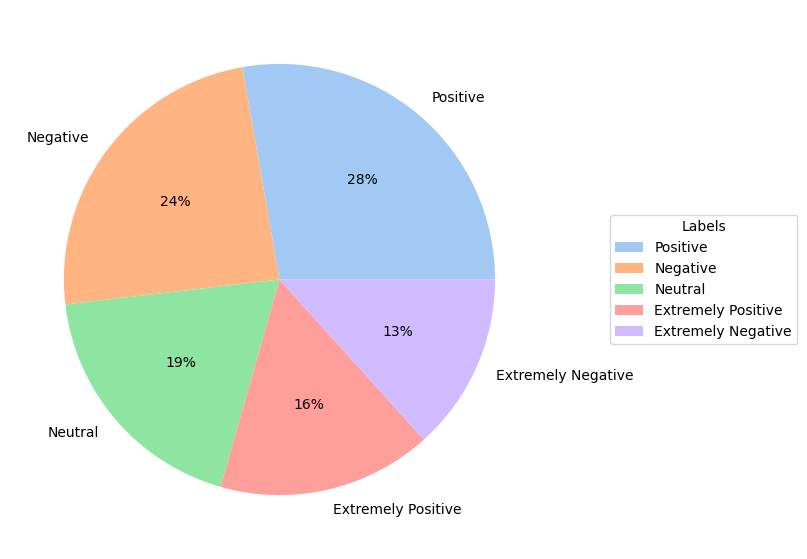

In [8]:
#Print the numbers of each class

print(df['Sentiment'].value_counts())

print()

#create pie chart
numbers = df['Sentiment'].value_counts()
labels=df['Sentiment'].value_counts().index

fig, ax = plt.subplots(figsize =(10, 7))
colors = sns.color_palette('pastel')[0:5]


plt.pie(numbers, labels = labels, colors = colors, autopct='%.0f%%')

ax.legend(labels,
		title ="Labels",
		loc ="center left",
		bbox_to_anchor =(1.1, 0, 0.5, 1))

plt.show()

# Splitting dataset

Declaring the target and predicted column

In [9]:
X = df['OriginalTweet']
y = df['Sentiment']

Splitting the dataset in to a 80-10-10 train-test-valid splits

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Visualizing each of the split distributions of the dataset

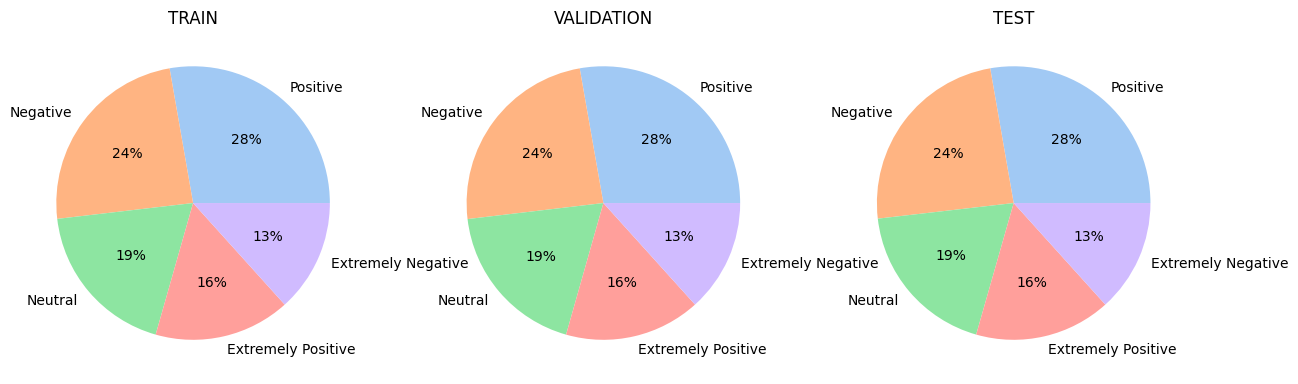

In [11]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.subplot(1, 3, 1)
colors = sns.color_palette('pastel')[0:5]

plt.pie(pd.Series(y_train).value_counts(), labels = pd.Series(y_train).value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("TRAIN")


plt.subplot(1, 3, 2)
plt.pie(pd.Series(y_val).value_counts(), labels=pd.Series(y_val).value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("VALIDATION")

plt.subplot(1, 3, 3)
plt.pie(pd.Series(y_test).value_counts(), labels=pd.Series(y_test).value_counts().index, colors = colors, autopct='%.0f%%')
plt.title("TEST")

plt.show()

# Pre-processing

Since the prediction column values are categorical values, need to convert those categorical labels into numerical forms or encoding the labels splits into integers. 

In [12]:
label_encoder = LabelEncoder() # Initialize the LabelEncoder

# Both learns the mapping and transforms the y_train labels accordingly.
y_train = label_encoder.fit_transform(y_train) 

# Applies the same mapping learned from the train train split to other splits to ensure consistent encoding
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Converting the integer-encoded labels into one-hot encoded format
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Cleaning the text by defining a function (preprocess_text)

In [13]:
def preprocess_text(text):
    text = text.lower() #ensures that the text is uniform in case
    text = re.sub(r'(covid[-_]?19|covid2019|covid[-_]?2019|corona[-_]?virus|corona|covid)', 'covid', text) #normalization to reduce variance in texts/terms
    text = re.sub(r'http\S+', '', text) #eliminate web links from the text
    text = re.sub(r'@\w+', '', text) # removes any social media handles
    text = re.sub(r'#', '', text) #removes any hashtags from texts
    text = re.sub(r'\n', ' ', text) #removes any new lines from the texts
    text = re.sub(r'\t', ' ', text) #replaces any tab characters with a space
    text = re.sub(r'\r', ' ', text) #replaces any carriage return characters with a space
    text = re.sub(r'â|â’', "'", text) #replaces any specific characters appearing due to encoding issues with an apostrophe
    text = re.sub(r'\x92|\xa0|\x85|\x95', '', text) #removes various unwanted characters appearing due to encoding artifacts
    text = contractions.fix(text) # expands shortened words using the contractions library
    text = re.sub(r'[^\w\s]', ' ', text) # removes all characters that are not word characters or whitespace
    return text #returns the cleaned and processed text

Cleaning the texts in all of the splits but not Lematizing since it may generalize terms and lose the sentiments

In [14]:
X_train = np.array([preprocess_text(text) for text in X_train])
X_val = np.array([preprocess_text(text) for text in X_val])
X_test = np.array([preprocess_text(text) for text in X_test])

# Tokenizing the texts

Also, getting the word counts from each splits without limiting vocabulary size

In [15]:
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)
word_counts = len(tokenizer.word_index) + 1  # vocabulary size
print("Numbers of unique words present in the TRAIN split:", word_counts)

# print()

# tokenizer_test  = Tokenizer(filters='')
# tokenizer_test.fit_on_texts(X_val)
# word_counts_test = len(tokenizer_test.word_index) + 1  # vocabulary size
# print("Numbers of unique words present in the TEST split:", word_counts_test)

# print()

# tokenizer_val = Tokenizer(filters='')
# tokenizer_val.fit_on_texts(X_val)
# word_counts_val = len(tokenizer_val.word_index) + 1  # vocabulary size
# print("Numbers of unique words present in the VALID split:", word_counts_val)

Numbers of unique words present in the TRAIN split: 40273


# Vectorizing the text

In [16]:
train_sequences = tokenizer.texts_to_sequences(X_train)

maxlen = max([len(seq) for seq in train_sequences])
print("Maximum length of all sequences:", maxlen)

Maximum length of all sequences: 65


# Padding the sequences

Post-padding the sequences

In [17]:
padded_train_sequences = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
print("Padded TRAINING Sequences Shape:", padded_train_sequences.shape)

Padded TRAINING Sequences Shape: (32925, 65)


In [18]:
# padded_train_sequences

Checking the longest sequence, size and sentence in train split

In [19]:
longest_sequence_index = np.argmax([len(seq) for seq in train_sequences])

# Get the longest sequence and its corresponding original sentence
longest_sequence = train_sequences[longest_sequence_index]
longest_sentence = X_train[longest_sequence_index]

print(f"Longest sequence index: \n{longest_sequence_index}")
print()
print(f"Longest sequence: \n{longest_sequence}")
print()
print(f"Longest sequence length: \n{len(longest_sequence)}")
print()
print(f"Longest sentence: \n{longest_sentence}")

Longest sequence index: 
7588

Longest sequence: 
[12, 197, 3, 78, 49, 12, 197, 3, 704, 424, 1144, 1, 437, 12, 415, 61, 1, 2, 132, 12, 197, 6, 352, 5613, 12, 197, 3, 78, 557, 16, 6, 9290, 7, 589, 15550, 3, 29, 192, 424, 1144, 1, 437, 5, 25, 23623, 132, 12, 197, 3, 78, 49, 9, 2929, 12, 40, 14, 64, 68, 197, 3, 78, 49, 59, 47, 52]

Longest sequence length: 
65

Longest sentence: 
i want to go shopping i want to walk w o the thought i might get the covid virus i want a real hug i want to go eat at a dine in restaurant ohhh to be free w o the thought of that darn virus i want to go shopping for shoes i do not need just want to go shopping   no more online 


In [20]:
# For Validation set
val_sequences = tokenizer.texts_to_sequences(X_val)
padded_val_sequences = pad_sequences(val_sequences, maxlen=maxlen, padding='post')

print("Padded VALIDATION Sequences Shape:", padded_val_sequences.shape)

Padded VALIDATION Sequences Shape: (4116, 65)


In [21]:
# For test set
test_sequences = tokenizer.texts_to_sequences(X_test)
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

print("Padded TEST Sequences Shape:", padded_test_sequences.shape)

Padded TEST Sequences Shape: (4116, 65)


# Creating the Embedding matrix using GloVe embedding

In [22]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix







embedding_dim = 100
filepath = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embedding_matrix = create_embedding_matrix(filepath, tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Percent of vocabulary covered: {round(nonzero_elements/word_counts*100, 2)}%")

Percent of vocabulary covered: 67.51%


Checking "non-covering" word percentage

In [23]:
# Get the words that are not covered by GloVe
not_covered_words = []
for word, idx in tokenizer.word_index.items():
    if np.count_nonzero(embedding_matrix[idx]) == 0:  # If the embedding vector is all zeros
        not_covered_words.append(word)

# Print some of the words that are not covered
print(f"Total uncovered words: {len(not_covered_words)}")
print()
print("Sample of uncovered words:", not_covered_words[:50])

Total uncovered words: 13083

Sample of uncovered words: ['covid', 'toiletpaper', 'socialdistancing', 'covidcrisis', 'covidpandemic', 'covidoutbreak', 'coviduk', 'stayhome', 'stayathome', 'stayhomesavelives', 'panicbuying', 'stophoarding', 'covidupdate', 'stoppanicbuying', 'staysafe', 'quarantinelife', 'handsanitizer', 'toiletpaperpanic', 'toiletpapercrisis', 'covidlockdown', 'covidusa', 'covidindia', 'panicbuyinguk', 'sanitiser', 'onlineshopping', 'toiletpaperapocalypse', 'washyourhands', 'supplychain', 'socialdistanacing', 'covidcrisisuk', 'panicshopping', 'covidiots', 'pricegouging', 'selfisolation', 'covidaustralia', 'covidau', 'flattenthecurve', 'stopstockpiling', 'staysafestayhome', 'auspol', 'covidpocolypse', 'covidupdates', 'stockup', 'groceryshopping', 'chinesevirus', 'mrx', 'quaratinelife', 'covidchallenge', 'shelterinplace', 'lockdownuk']


# The Dataset is ready to be fed to the neural network upto this point.

* Train features = padded_train_sequences 
* Train target = y_train


* Validation features = padded_val_sequences 
* Validation target = y_val


* Test features = padded_test_sequences 
* Test target = y_test


In [24]:
print(padded_train_sequences)  # training feature
print(y_train)  # training target

print()
print("=========================================================")
print()

print(len(padded_train_sequences))  # training feature length
print(len(y_train))  # training target length

[[   3  143  286 ...    0    0    0]
 [  51   36   80 ...    0    0    0]
 [ 518   15   51 ...    0    0    0]
 ...
 [2575    3   79 ...    0    0    0]
 [8961    1  186 ...    0    0    0]
 [  37  359    4 ...    0    0    0]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


32925
32925


# Modeling

In [26]:
clear_session ()

model = Sequential()

model.add(Embedding(word_counts,                   # using the pre-trained embedding matrix for word embeddings
                    embedding_dim,                       # convert each word in a sequence to a dense vector of size embedding_dim
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

model.add(SpatialDropout1D(0.3)) # dropout to the embedding layer to prevent overfitting (randomly drops entire feature maps rather than individual elements)

model.add(Bidirectional(LSTM(units=64, return_sequences=True))) # bidirectional LSTM layer has 64 units and outputs sequence
model.add(BatchNormalization()) # stabilizing and accelerating the training by normalizing each layer’s input
model.add(Dropout(0.25)) 

model.add(Bidirectional(LSTM(units=32, return_sequences=False))) # bidirectional LSTM layer has 32 units and outputs sequence
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(24, activation='relu', kernel_regularizer=l2(0.05))) # This dense layer consisting of 24 neurons with ReLU activation functions process the LSTM outputs
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.05))) # This dense layer consisting of 16 neurons with ReLU activation functions process the LSTM outputs
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax')) # output layer of 5 neurons for 5 classes ; softmax activation to output the class with maximum probability 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Building the model

In [27]:
model.build((padded_train_sequences.shape))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32925, 65, 100)       │     4,027,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (32925, 65, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32925, 65, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32925, 65, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32925, 65, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (32925, 64)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32925, 64)            │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32925, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32925, 24)            │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32925, 24)            │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32925, 24)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32925, 16)            │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32925, 16)            │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32925, 16)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32925, 5)             │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,155,969 (15.85 MB)

 Trainable params: 4,155,505 (15.85 MB)

 Non-trainable params: 464 (1.81 KB)

# Visualizing the built model

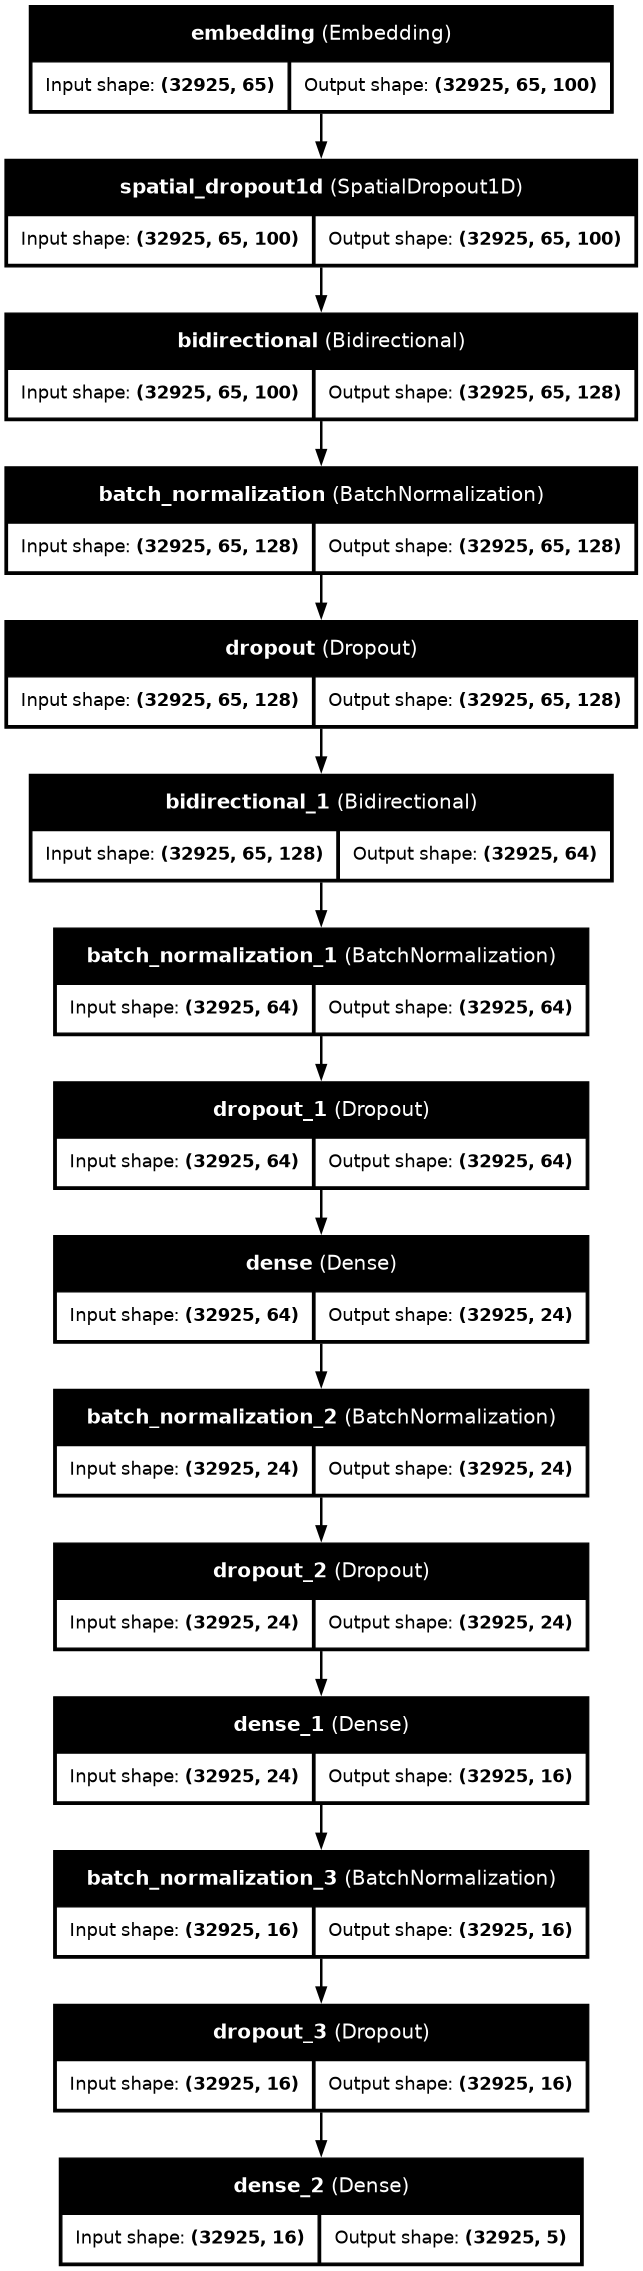

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=90)

# Setting up the relevant training elements and tuning the hyperparameters



```
verbose=1: povides a detailed output with progress bars, metrics for each epoch, and any additional callback messages

verbose=0: no progress bars or messages will be shown

verbose=2: shows only one line per epoch with epoch and metric updates but no progress bar
```

In [29]:
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original) # calculates the weight for each class based on its frequency
class_weights = dict(enumerate(class_weights))

num_epochs = 200 # setting up epoch numbers

reduce_lr = ReduceLROnPlateau( # reduces the learning rate f the val_loss does not improve 
    monitor='val_loss',
    factor=0.2, # reduces the learning rate by a factor of 0.2 if......
    patience=3, # ......if the val_loss does not improve for 3 consecutive epochs
    min_lr=1e-6,# the minimum threshold for the learning rate
    verbose=1
)

checkpoint = ModelCheckpoint( # saves the model weights whenever val_accuracy improves
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True, # ensures that only the best weights are saved based on validation accuracy
    mode='max',
    verbose=1 
)

early_stop = EarlyStopping(monitor='val_loss', patience=10) # monitors the val_loss and stops training if it doesn’t improve for 10 consecutive epochs 

In [30]:
model.compile(loss = 'categorical_crossentropy', # calculates the loss by comparing the model’s predicted probabilities to the one-hot-encoded true labels
              optimizer=Adam(learning_rate=0.000001, clipnorm=1.0), # clipnorm=1.0 prevents the gradients from growing too large by capping their norm to 1
              metrics = ['accuracy']) # evaluation metric during training

In [31]:
history = model.fit(padded_train_sequences, # input sequences
                    y_train, # output labels of those input sequences
                    validation_data=(padded_val_sequences, y_val), # validation data and labels
                    epochs=num_epochs, #epoch numbers
                    class_weight=class_weights, # counteracts class imbalance by adjusting the model’s loss calculation by giving different weights to each class
                    callbacks =[reduce_lr, early_stop, checkpoint], # applies the learning rate scheduler, model checkpointing, and early stopping during training
                    batch_size=32, # the number of samples processed before updating the model weights
                    verbose=1)

Epoch 1/200
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1884 - loss: 4.8976
Epoch 1: val_accuracy improved from -inf to 0.17274, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.1884 - loss: 4.8976 - val_accuracy: 0.1727 - val_loss: 4.5651 - learning_rate: 1.0000e-06
Epoch 2/200
1028/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1891 - loss: 4.9028
Epoch 2: val_accuracy improved from 0.17274 to 0.17784, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.1891 - loss: 4.9028 - val_accuracy: 0.1778 - val_loss: 4.5468 - learning_rate: 1.0000e-06
Epoch 3/200
1027/1029 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1893 - loss: 4.8891
Epoch 3: val_accuracy improved from 0.17784 to 0.18149, saving model to best_model.keras
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.1893 - loss: 4.8891 - val_accuracy: 0.1815 - val_loss: 4.5270 - learning_rate: 1.0000e-06
Epoch 4/200
1027/10

# Plotting the training/validation accuracy and loss curves

In [ ]:
plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

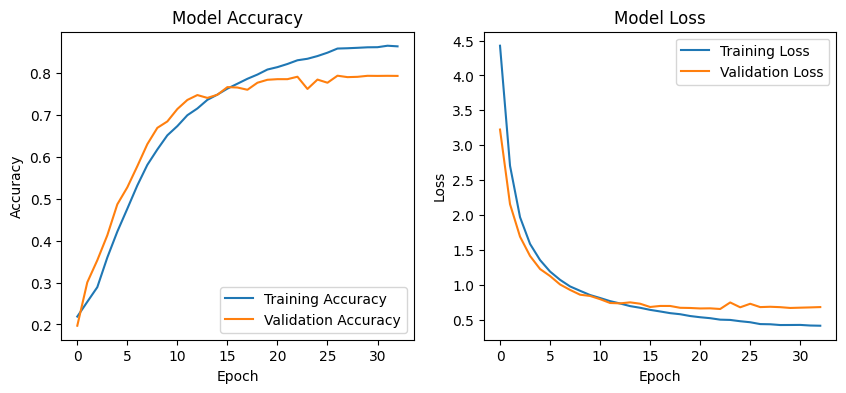

# Saving and loading the model

In [25]:
# Saving the model from the file

#model.save('model_9.h5')


# Load the model from the file

#model = load_model('/kaggle/working/model_9.h5')

model = load_model('/kaggle/input/multiclass-twitter-sentiment-analysis-model/model_9.h5')


# Testing the model's accuracy

In [49]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(padded_test_sequences, y_test, verbose=1)
print(f'Test Accuracy: {(test_accuracy * 100):.2f}%')

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8037 - loss: 0.6446
Test Accuracy: 79.96%


# Plotting the confusion Matrix & classification report

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


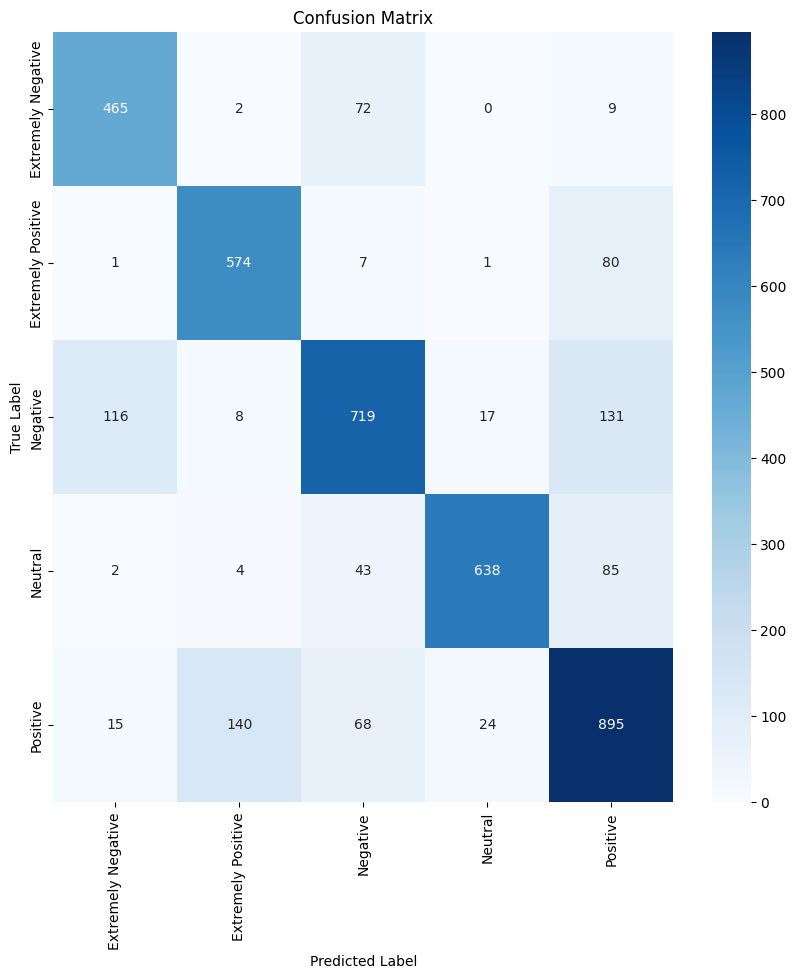

In [51]:
# Predict the labels for test data
y_pred = np.argmax(model.predict(padded_test_sequences), axis=-1)
y_true = np.argmax(y_test, axis=-1)

class_names = label_encoder.classes_

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.savefig('cf.png')
plt.show()

In [54]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


                    precision    recall  f1-score   support

Extremely Negative       0.77      0.87      0.82       548
Extremely Positive       0.78      0.88      0.83       663
          Negative       0.77      0.76      0.76       991
           Neutral       0.91      0.85      0.88       772
          Positive       0.80      0.75      0.77      1142

          accuracy                           0.81      4116
         macro avg       0.81      0.82      0.81      4116
      weighted avg       0.81      0.81      0.81      4116



